A notebook which will contain plots showing data summaries for every year combined.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

range(0, 10)


In [14]:
years=range(2007,2020)
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [17]:
display(Markdown('''## All years Summary ## '''))

## All years Summary ## 

In [16]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

## Yearly model-data comparisons of nutrients, chlorophyll, temperature and salinity between 201905 runs and WADE observations

In [20]:
##### Loading in pickle file data
dictbot=dict()
dictCTD=dict()
saveloc='/ocean/kflanaga/MEOPAR/savedData'

for Y in years:
    with open(os.path.join(saveloc,f'data_WADE_{modelversion}_{Y}.pkl'),'rb') as hh:
        dictbot[Y]=pickle.load(hh)
    with open(os.path.join(saveloc,f'data_CTD_{modelversion}_{Y}.pkl'),'rb') as hh:
        dictCTD[Y]=pickle.load(hh)
    
data=pd.concat(dictbot.values(), ignore_index=True)
data_CTD=pd.concat(dictCTD.values(), ignore_index=True)

In [21]:
def byDepth(data,ax,obsvar,modvar,lims):
    ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
    l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(data,datreg,ax,obsvar,modvar,lims):
    ps=[]
    for ind, iregion in enumerate(data.Basin.unique()):
        ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
                color = colors[ind], label=iregion)
        ps0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                        cols=(colors[ind],),lname=iregion)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byStation(data,datstat,ax,obsvar,modvar,lims,region):
    ps=[]
    for ind, istation in enumerate(data[data['Basin'] == region].Station.unique()):
        ax.plot(datstat[istation]['Lon'], datstat[istation]['Lat'],'.',
                    color = colors[ind], label=istation)
        ps0=et.varvarPlot(ax,datstat[istation],obsvar,modvar,
                        cols=(colors[ind],),lname=istation)
        ps.append(ps0)
    l=ax.legend(title='Stations',title_fontsize=20,handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def hist2d(data,ax,obsvar,modvar,lims,fontsize=12):
    ax.plot((-250,250),(-250,250),'k-',alpha=.2)
    ii=(~np.isnan(data[obsvar]))&(~np.isnan(data[modvar]))
    counts, xedges, yedges, ps=ax.hist2d(data.loc[ii,[obsvar]].values.flatten(),
                                      data.loc[ii,[modvar]].values.flatten(),bins=25*3,norm=LogNorm())
    cb=fig.colorbar(ps,ax=ax,label='Count',shrink=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_ylabel('Modeled',fontsize=fontsize)
    ax.set_xlabel('Observed',fontsize=fontsize)
    plt.tight_layout()
    return ps

def bySeason_hist2d(seaons,ax,obsvar,modvar,lims):
    for axj in ax:
        for axi in axj:
            axi.plot(lims,lims,'k-')
            axi.set_xlim(lims)
            axi.set_ylim(lims)
            axi.set_aspect(1)
            axi.set_xlabel('Obs')
            axi.set_ylabel('Model')
    jp=hist2d(seaons[0],ax[0][0],obsvar,modvar,lims)
    ax[0][0].set_title('Jan-Mar')
    jp=hist2d(seaons[1],ax[0][1],obsvar,modvar,lims)
    ax[0][1].set_title('Apr')
    jp=hist2d(seaons[2],ax[1][0],obsvar,modvar,lims)
    ax[1][0].set_title('May-Aug')
    jp=hist2d(seasons[3],ax[1][1],obsvar,modvar,lims)
    ax[1][1].set_title('Sep-Dec')
    return 

def bySeason(seaons,ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],seaons[0],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],seaons[1],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],seaons[2],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],seasons[3],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

In [22]:
def multi_station_graph(data,datstat,figrange,obsvar,modvar,regions,down=6,figsize=(14,40)):
    ''' A function that creates a series of scatter plots and maps for each region
    
    :arg figrange: A pair of values that will decide the range of the graph. Should always
                    should always be larger than the maximum value of the variable.
    :type : tuple
                    
    :arg obsvar,modvar: The name of the observed and model variables you wish to compare to each other.
    :type :string
    
    :are regions: The names of all of the basins you wish to look at 
    :type : list of strings
    
    :arg down: A number which should be equal to the number of regions you are looking at
    :type : integer
    
    :arg figsize: a pair of values that decide the size of the entire figure
    '''
    fig, ax = plt.subplots(down,2,figsize = figsize)
    for d,r in zip(range(down),regions):
        ps=byStation(data,datstat,ax[d][0],obsvar,modvar,figrange,r)
        ax[d][0].set_title(f'{obsvar} ($\mu$M) in {r} by Station');

        with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
            viz_tools.plot_coastline(ax[d][1], grid, coords = 'map',isobath=.1)

        for ind, istation in enumerate(data[data['Basin'] == r].Station.unique()):
            ax[d][1].plot(datstat[istation]['Lon'], datstat[istation]['Lat'],'.',
                color = colors[ind], label=istation)
        ax[d][1].set_ylim(47, 49)
        ax[d][1].legend(bbox_to_anchor=[1,.6,0,0])
        ax[d][1].set_xlim(-124, -122);
        ax[d][1].set_title(f'Observation Locations for {r}');

def logt(x):
    return np.log10(x+.001)

In [23]:
#Adding extra columns to assist in analysis.
data_CTD['log_Chl']=logt(data_CTD['Chl'])
data_CTD['log_mod_diatoms']=logt(data_CTD['mod_diatoms']*1.8)
data_CTD['log_mod_ciliates']=logt(data_CTD['mod_ciliates']*1.8)
data_CTD['log_mod_flagellates']=logt(data_CTD['mod_flagellates']*1.8)
data_CTD['log_mod_Chl']=logt((data_CTD['mod_diatoms']*1.8)+(data_CTD['mod_ciliates']*1.8)+(data_CTD['mod_flagellates']*1.8))

# defning a dictionary that brakes the data down by individual stations
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datstat_CTD=dict()
for ind, istation in enumerate(data_CTD.Station.unique()):
    datstat_CTD[istation]=data_CTD.loc[data_CTD.Station == istation]
    
datreg=dict()
for iregion in data.Basin.unique():
    datreg[iregion] = data.loc[data.Basin==iregion]   

datreg_CTD=dict()
for iregion in data_CTD.Basin.unique():
    datreg_CTD[iregion] = data_CTD.loc[data_CTD.Basin==iregion]


/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
# Creating seperate dataframes for each season (includes only dataabove 15 metre depth.)

JFMd=dict()
Aprd=dict()
MJJAd=dict()
SONDd=dict()
for i in years:
    JFMd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,4,1)),:]
    Aprd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,5,1))&(data.dtUTC>dt.datetime(i,4,1)),:]
    MJJAd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,9,1))&(data.dtUTC>dt.datetime(i,5,1)),:]
    SONDd[i]=data.loc[iz&(data.dtUTC>dt.datetime(i,9,1)),:]
JFM=pd.concat(JFMd.values(), ignore_index=True)
Apr=pd.concat(Aprd.values(), ignore_index=True)
MJJA=pd.concat(MJJAd.values(), ignore_index=True)
SOND=pd.concat(SONDd.values(), ignore_index=True)

iz_CTD=(data_CTD.Z<15)
JFM_CTD=data_CTD.loc[iz_CTD&(data_CTD.dtUTC<=dt.datetime(year,4,1)),:]
Apr_CTD=data_CTD.loc[iz_CTD&(data_CTD.dtUTC<=dt.datetime(year,5,1))&(data_CTD.dtUTC>dt.datetime(year,4,1)),:]
MJJA_CTD=data_CTD.loc[iz_CTD&(data_CTD.dtUTC<=dt.datetime(year,9,1))&(data_CTD.dtUTC>dt.datetime(year,5,1)),:]
SOND_CTD=data_CTD.loc[iz_CTD&(data_CTD.dtUTC>dt.datetime(year,9,1)),:]

SyntaxError: invalid syntax (<ipython-input-25-3d2eabd6771f>, line 4)

In [10]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, JFM':JFM,
                      'z < 15 m, Apr':Apr,
                      'z < 15 m, MJJA':MJJA,
                      'z < 15 m, SOND': SOND,})
for iregion in data.Basin.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

statsubs_CTD=OrderedDict({'z < 15 m':data_CTD.loc[data_CTD.Z<15],
                      '15 m < z < 22 m':data_CTD.loc[(data_CTD.Z>=15)&(data_CTD.Z<22)],
                      'z >= 22 m':data_CTD.loc[data_CTD.Z>=22],
                      'z > 50 m':data_CTD.loc[data_CTD.Z>50],
                      'all':data_CTD,
                      'z < 15 m, JFM':JFM_CTD,
                      'z < 15 m, Apr':Apr_CTD,
                      'z < 15 m, MJJA':MJJA_CTD,
                      'z < 15 m, SOND': SOND_CTD,})
for iregion in data_CTD.Basin.unique():
    statsubs_CTD[iregion]=datreg_CTD[iregion]
statsubs_CTD.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, JFM', 'z < 15 m, Apr', 'z < 15 m, MJJA', 'z < 15 m, SOND', 'Strait of Juan de Fuca', 'Main Basin', 'Hood Canal Basin', 'Strait of Georgia', 'Admiralty Inlet', 'Whidbey Basin', 'South Basin'])

## Map of observation locations in each basin

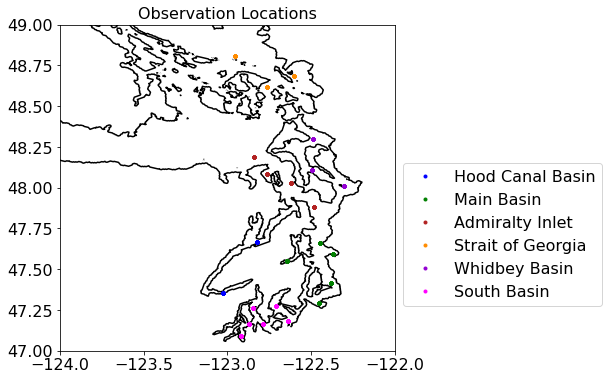

In [11]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
for ind, iregion in enumerate(data.Basin.unique()):
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

# Absolute Salinity (g/kg)

### Table containing evaluation statistics for relevant subsets

In [12]:
# Setting Variable for Temperature. 
obsvar='SA'
modvar='mod_vosaline'
seasons=[JFM_CTD,Apr_CTD,MJJA_CTD,SOND_CTD]

In [13]:
statsDict_CTD={year:dict()}
statsDict_CTD[year]['SA']=OrderedDict()
for isub in statsubs_CTD:
    print(isub)
    statsDict_CTD[year]['SA'][isub]=dict()
    var=statsDict_CTD[year]['SA'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]],
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_CTD[year]['SA'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, JFM
z < 15 m, Apr
z < 15 m, MJJA
z < 15 m, SOND
Strait of Juan de Fuca
Main Basin
Hood Canal Basin
Strait of Georgia
Admiralty Inlet
Whidbey Basin
South Basin


### Model vs Observed comparisons by depth and region

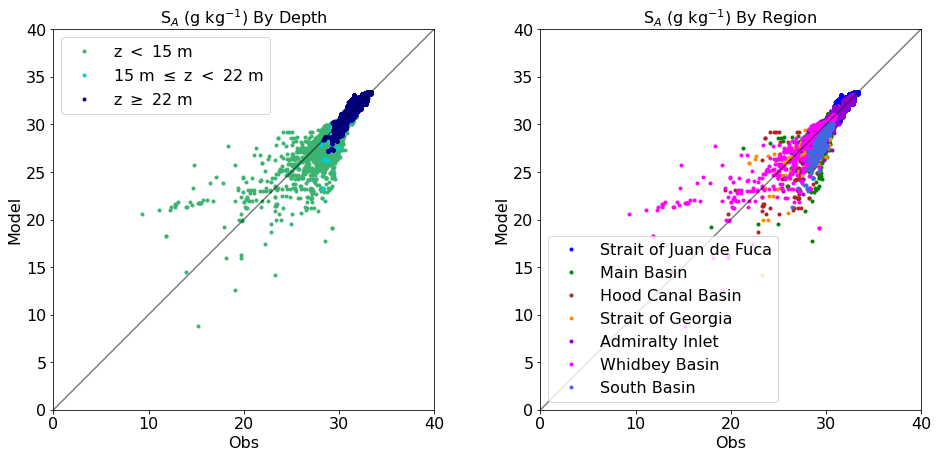

In [14]:
### Pull 
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data_CTD,ax[0],obsvar,modvar,(0,40))
ax[0].set_title('S$_A$ (g kg$^{-1}$) By Depth')

ps,l=byRegion(data_CTD,datreg_CTD,ax[1],obsvar,modvar,(0,40))
ax[1].set_title('S$_A$ (g kg$^{-1}$) By Region');

### A closer look at Salinity in South Basin

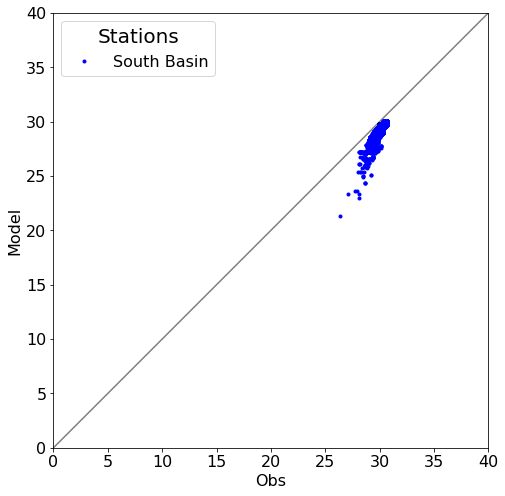

In [15]:
# Look at the salinity and divide up by depth. 
lims=(0,40)
ps=[]
fig, ax=plt.subplots(1,1,figsize=(12,8))
ax.plot(datreg_CTD['South Basin']['Lon'], datreg_CTD['South Basin']['Lat'],'.',
            color = colors[ind], label='South Basin')
ps0=et.varvarPlot(ax,datreg_CTD['South Basin'],obsvar,modvar,
             cols=(colors[0],),lname='South Basin')
ps.append(ps0)
l=ax.legend(title='Stations',title_fontsize=20,handles=[ip[0][0] for ip in ps])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.plot(lims,lims,'k-',alpha=.5)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect(1)

### 2D Histogram of model vs observed

Text(0.5, 1.0, 'S$_A$ (g kg$^{-1}$)')

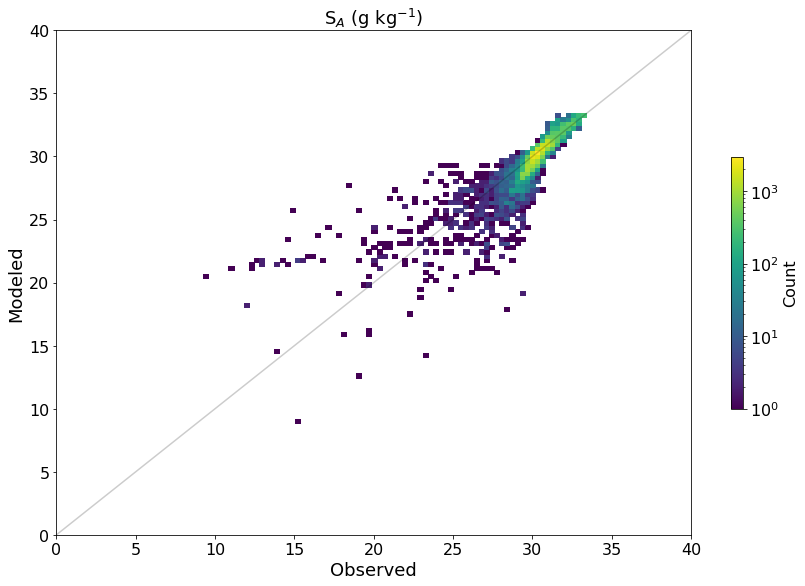

In [16]:
fig, ax = plt.subplots(1,1,figsize= (12,8))
ps = hist2d(data_CTD,ax,obsvar,modvar,(0,40),fontsize=18)
ax.set_title('S$_A$ (g kg$^{-1}$)',fontsize=18)

### Model vs observed comparisons for multiple seasons

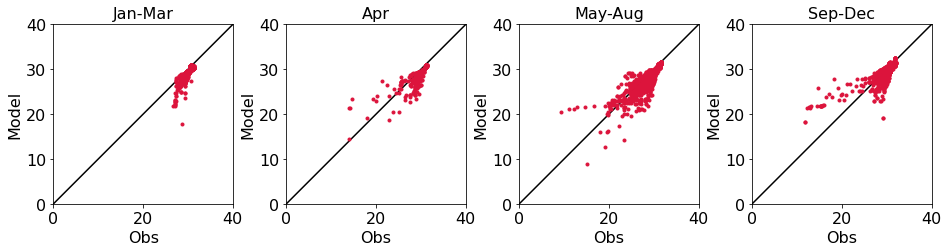

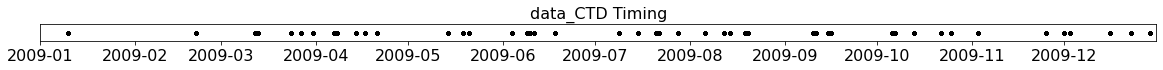

In [17]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(seasons,ax,obsvar,modvar,(0,40))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

# Conservative Temperature

In [18]:
#Setting variables for temperature.
obsvar='CT'
modvar='mod_votemper'
seasons=[JFM_CTD,Apr_CTD,MJJA_CTD,SOND_CTD]

In [19]:
statsDict_CTD[year]['CT']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_CTD[year]['CT'][isub]=dict()
    var=statsDict_CTD[year]['CT'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]],
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_CTD[year]['CT'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Model vs Observed comparisons by depth and region

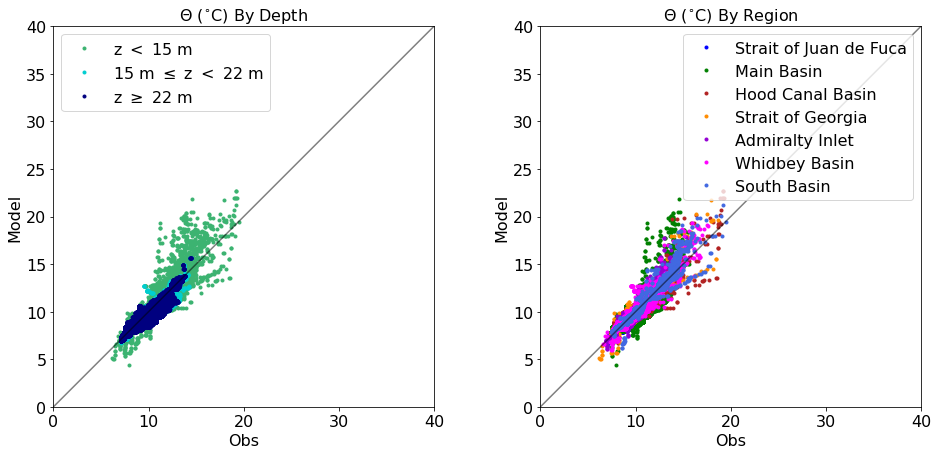

In [20]:
mv=(0,40)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data_CTD,ax[0],obsvar,modvar,mv)
ax[0].set_title('$\Theta$ ($^{\circ}$C) By Depth')

ps,l=byRegion(data_CTD,datreg_CTD,ax[1],obsvar,modvar,mv)
ax[1].set_title('$\Theta$ ($^{\circ}$C) By Region');

### 2D Histogram of model vs observed

Text(0.5, 1.0, '$\\Theta$ ($^{\\circ}$C)')

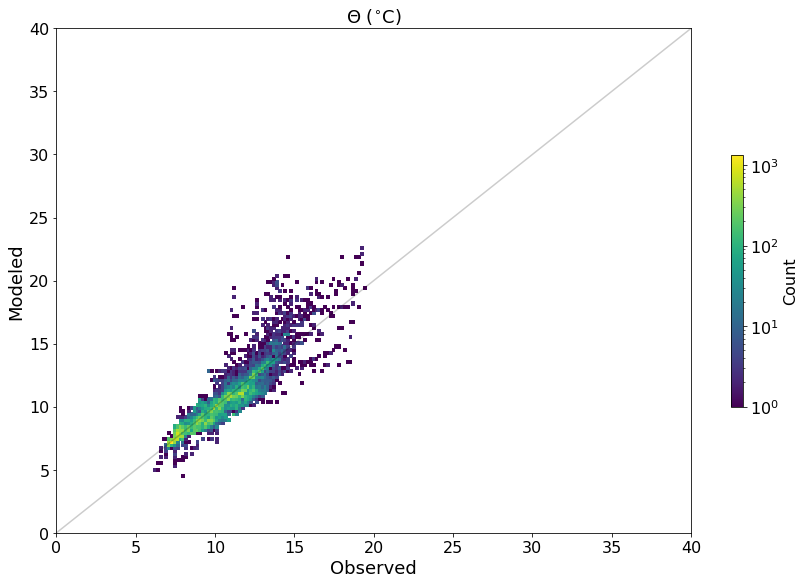

In [21]:
fig, ax = plt.subplots(1,1,figsize= (12,8))
ps = hist2d(data_CTD,ax,obsvar,modvar,(0,40),fontsize=18)
ax.set_title('$\Theta$ ($^{\circ}$C)',fontsize=18)

### Model vs observed comparisons for multiple seasons

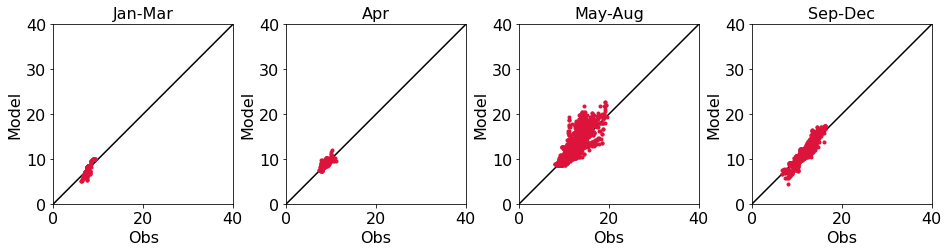

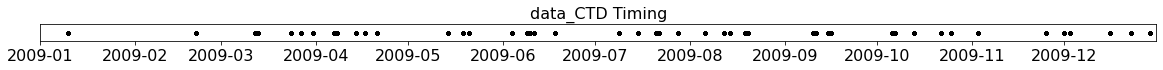

In [22]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(seasons,ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

### Temperature-Salinity by Region

In [23]:
def tsplot(ax,svar,tvar):
    limsS=(0,36)
    limsT=(5,20)
    ss,tt=np.meshgrid(np.linspace(limsS[0],limsS[1],20),np.linspace(limsT[0],limsT[1],20))
    rho=gsw.rho(ss,tt,np.zeros(np.shape(ss)))
    r=ax.contour(ss,tt,rho,colors='k')
    ps=list()
    for ind, iregion in enumerate(data_CTD.Basin.unique()):
        p=ax.plot(datreg_CTD[iregion][svar], datreg_CTD[iregion][tvar],'.',
                color = colors[ind], label=iregion)
        ps.append(p[0])
    l=ax.legend(handles=ps,bbox_to_anchor=(1.01,1))
    ax.set_ylim(limsT)
    ax.set_xlim(limsS)
    ax.set_ylabel('$\Theta$ ($^{\circ}$C)')
    ax.set_xlabel('S$_A$ (g kg$^{-1}$)')
    ax.set_aspect((limsS[1]-limsS[0])/(limsT[1]-limsT[0]))
    return

Text(0.5, 1.0, 'Modelled')

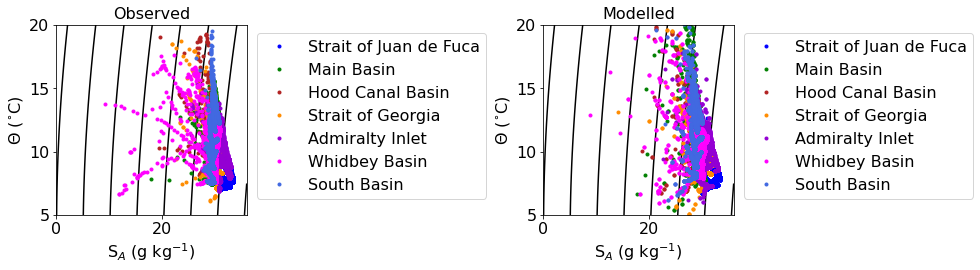

In [24]:
fig,ax=plt.subplots(1,2,figsize=(16,3.5))
tsplot(ax[0],'SA','CT')
ax[0].set_title('Observed')
tsplot(ax[1],'mod_vosaline','mod_votemper')
ax[1].set_title('Modelled')

# Chlorophyll 
(Hmmm, It seems that this gets remarkably worse with depth. Also, I think I may be adding up the values for the final chlorophyll section wrong.)

In [25]:
#Setting variables for Chlorophyll.
obsvar='log_Chl'
modvar='log_mod_diatoms'
seasons=[JFM_CTD,Apr_CTD,MJJA_CTD,SOND_CTD]

In [26]:
statsDict_CTD[year]['Chl']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_CTD[year]['Chl'][isub]=dict()
    var=statsDict_CTD[year]['Chl'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]], 
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_CTD[year]['Chl'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Model Diatoms vs Observed Chlorophyll comparisons by depth and region

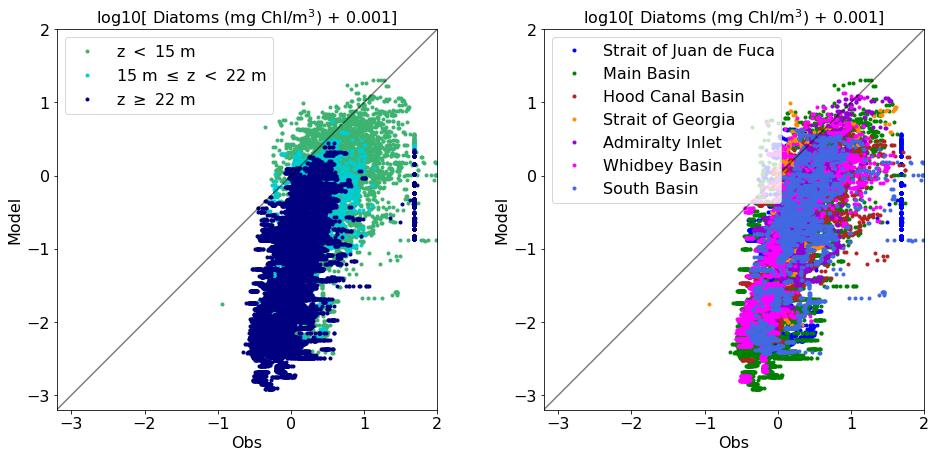

In [27]:
obsvar='log_Chl'
modvar='log_mod_diatoms'

mv=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data_CTD,ax[0],obsvar,modvar,mv)
ax[0].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]')

ps,l=byRegion(data_CTD,datreg_CTD,ax[1],obsvar,modvar,mv)
ax[1].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]');

### 2D Histogram of model diatoms vs observed ciliates

Text(0.5, 1.0, 'log10[ Diatoms (mg Chl/m$^3$) + 0.001]')

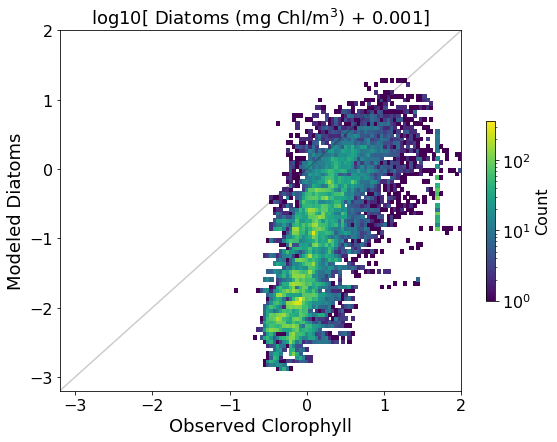

In [28]:
obsvar='log_Chl'
modvar='log_mod_diatoms'

fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = hist2d(data_CTD,ax,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_ylabel('Modeled Diatoms')
ax.set_xlabel('Observed Clorophyll')              
ax.set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]',fontsize=18)

## Model vs observed comparisons for multiple seasons

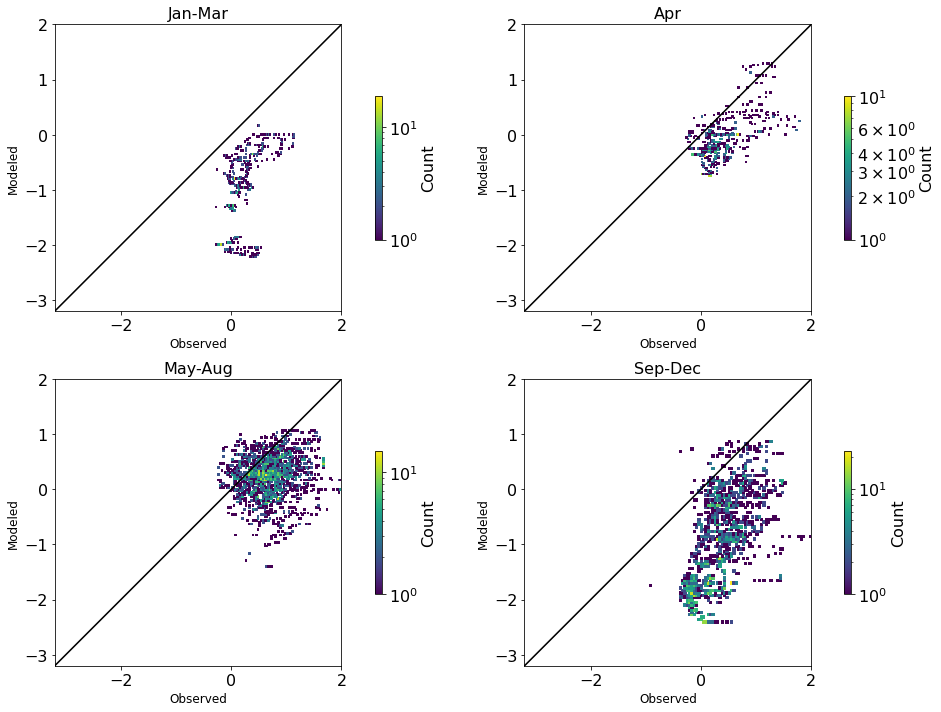

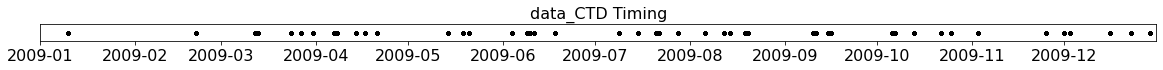

In [29]:
seasons=[JFM_CTD,Apr_CTD,MJJA_CTD,SOND_CTD]
fig, ax = plt.subplots(2,2,figsize = (16,10))
bySeason_hist2d(seasons,ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

### 2D Histogram of model ciliates vs observed chlorophyll

Text(0.5, 1.0, 'log10[ Ciliates (mg Chl/m$^3$) + 0.001]')

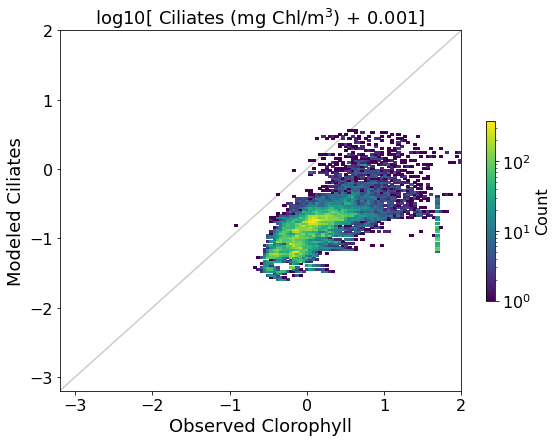

In [30]:
obsvar='log_Chl'
modvar='log_mod_ciliates'

fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = hist2d(data_CTD,ax,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_ylabel('Modeled Ciliates')
ax.set_xlabel('Observed Clorophyll')              
ax.set_title('log10[ Ciliates (mg Chl/m$^3$) + 0.001]',fontsize=18)

## Model Ciliates vs observed Chlorophyll comparisons for multiple seasons

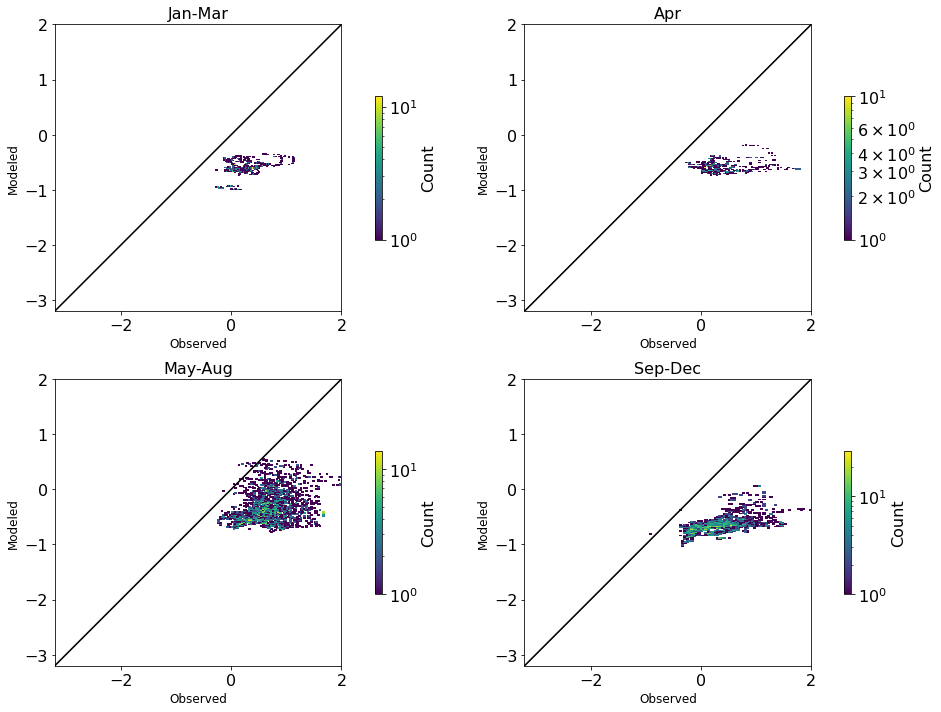

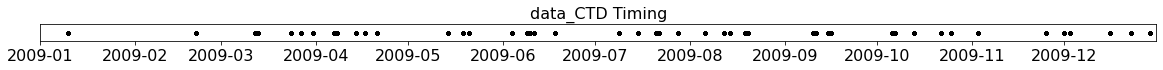

In [31]:
seasons=[JFM_CTD,Apr_CTD,MJJA_CTD,SOND_CTD]
fig, ax = plt.subplots(2,2,figsize = (16,10))
bySeason_hist2d(seasons,ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

### 2D Histogram of model cilliates vs observed Chlorophyll

Text(0.5, 1.0, 'log10[ flagellates (mg Chl/m$^3$) + 0.001]')

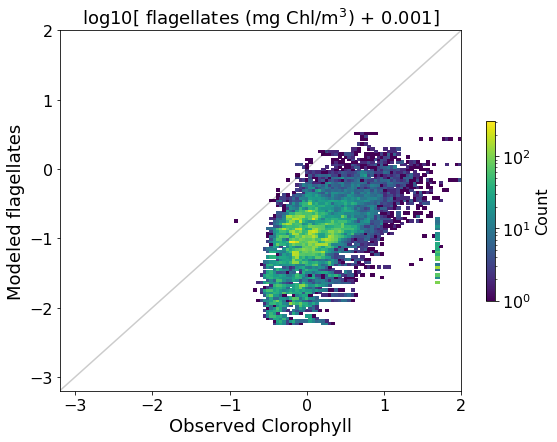

In [32]:
obsvar='log_Chl'
modvar='log_mod_flagellates'

fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = hist2d(data_CTD,ax,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_ylabel('Modeled flagellates')
ax.set_xlabel('Observed Clorophyll')              
ax.set_title('log10[ flagellates (mg Chl/m$^3$) + 0.001]',fontsize=18)

## Model flagellates vs observed Chlorophyll comparisons for multiple seasons

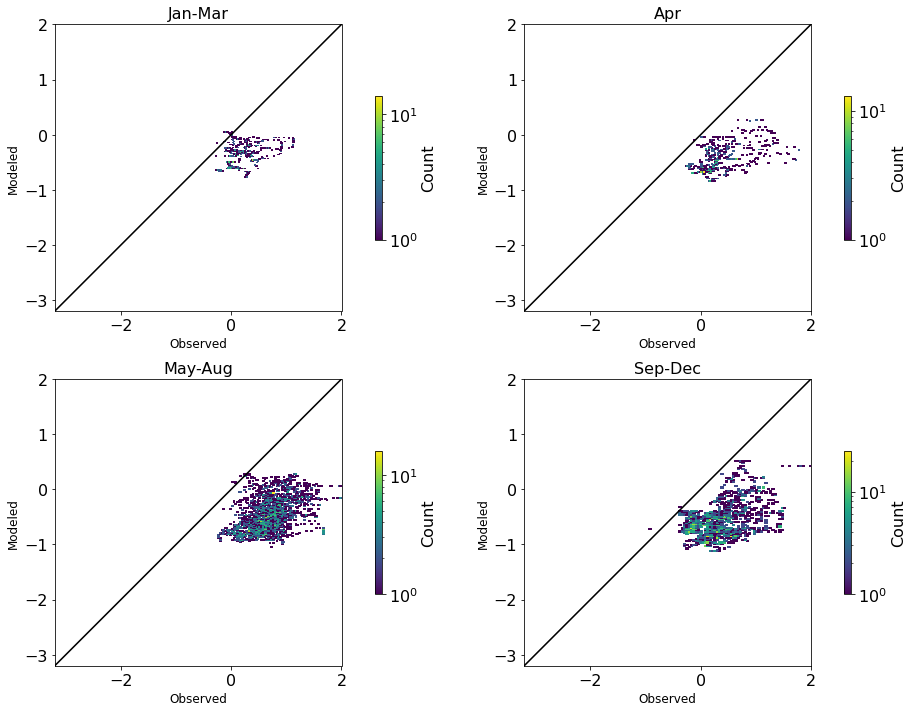

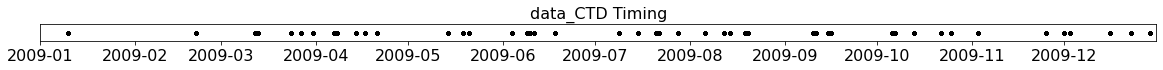

In [33]:
fig, ax = plt.subplots(2,2,figsize = (16,10))
bySeason_hist2d(seasons,ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

### 2D Histogram of model Chlorophyll vs observed Chlorophyll

In [34]:
def hist2d(data,ax,obsvar,modvar,lims,fontsize=12):
    ax.plot((-250,250),(-250,250),'k-',alpha=.2)
    ii=(~np.isnan(data[obsvar]))&(~np.isnan(data[modvar]))
    counts, xedges, yedges, ps=ax.hist2d(data.loc[ii,[obsvar]].values.flatten(),
                                      data.loc[ii,[modvar]].values.flatten(),bins=25*3,norm=LogNorm())
    cb=fig.colorbar(ps,ax=ax,label='Count',shrink=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_ylabel('Modeled',fontsize=fontsize)
    ax.set_xlabel('Observed',fontsize=fontsize)
    plt.tight_layout()
    return ps

def bySeason_hist2d(seaons,ax,obsvar,modvar,lims):
    for axj in ax:
        for axi in axj:
            axi.plot(lims,lims,'k-')
            axi.set_xlim(lims)
            axi.set_ylim(lims)
            axi.set_aspect(1)
            axi.set_xlabel('Obs')
            axi.set_ylabel('Model')
    jp=hist2d(seaons[0],ax[0][0],obsvar,modvar,lims)
    ax[0][0].set_title('Jan-Mar')
    jp=hist2d(seaons[1],ax[0][1],obsvar,modvar,lims)
    ax[0][1].set_title('Apr')
    jp=hist2d(seaons[2],ax[1][0],obsvar,modvar,lims)
    ax[1][0].set_title('May-Aug')
    jp=hist2d(seasons[3],ax[1][1],obsvar,modvar,lims)
    ax[1][1].set_title('Sep-Dec')
    return 

Text(0.5, 1.0, 'log10[ chlorophyll (mg Chl/m$^3$) + 0.001]')

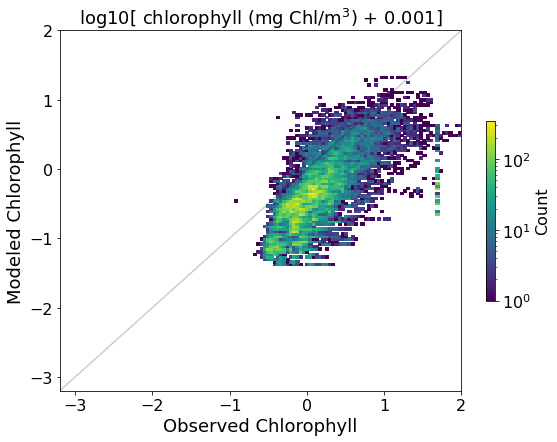

In [35]:
obsvar='log_Chl'
modvar='log_mod_Chl'

fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = hist2d(data_CTD,ax,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_ylabel('Modeled Chlorophyll')
ax.set_xlabel('Observed Chlorophyll')              
ax.set_title('log10[ chlorophyll (mg Chl/m$^3$) + 0.001]',fontsize=18)

## Model Chlorophyll vs observed Chlorophyll comparisons for multiple seasons

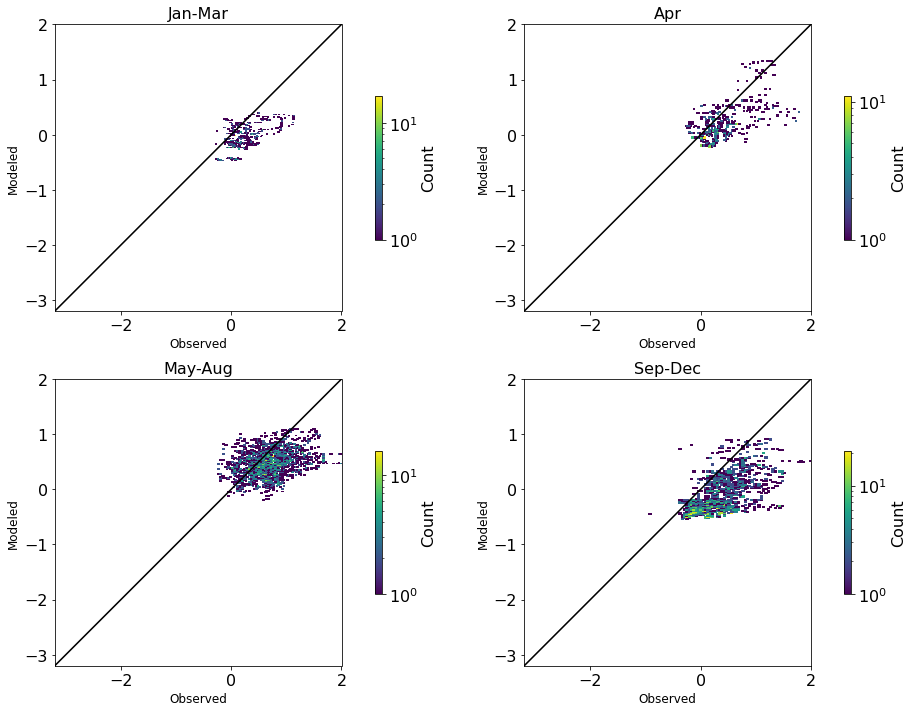

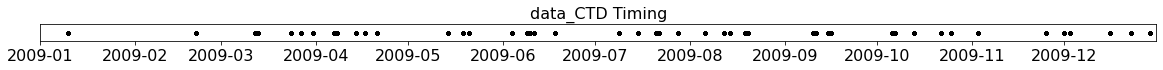

In [36]:
seasons=[JFM_CTD,Apr_CTD,MJJA_CTD,SOND_CTD]
fig, ax = plt.subplots(2,2,figsize = (16,10))
bySeason_hist2d(seasons,ax,obsvar,modvar,(-3.2,2))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

### Summary table of evaluation statistics for Temperature, Salinity, and Chlorophyll.

In [37]:
tbl,tdf=et.displayStats(statsDict_CTD[year],level='Variable',suborder=list(statsubs_CTD.keys()))
tbl

# Nitrate

### Table containing evaluation statistics for relevant subsets

In [38]:
# Defining variables needed for nitrate evaluations
obsvar='NO23'
modvar='mod_nitrate'
seasons=[JFM,Apr,MJJA,SOND]

In [39]:
statsDict={year:dict()}
statsDict[year]['NO3']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['NO3'][isub]=dict()
    var=statsDict[year]['NO3'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['NO3'],level='Subset',suborder=list(statsubs.keys()))
tbl

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, JFM
z < 15 m, Apr
z < 15 m, MJJA
z < 15 m, SOND
Hood Canal Basin
Main Basin
Admiralty Inlet
Strait of Georgia
Whidbey Basin
South Basin


/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1136: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(np.sum((mod-obs)**2)/len(mod))
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1132: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-np.mean(obs))+np.abs(obs-np.mean(obs)))**2)


### Model vs Observed comparisons by depth and region

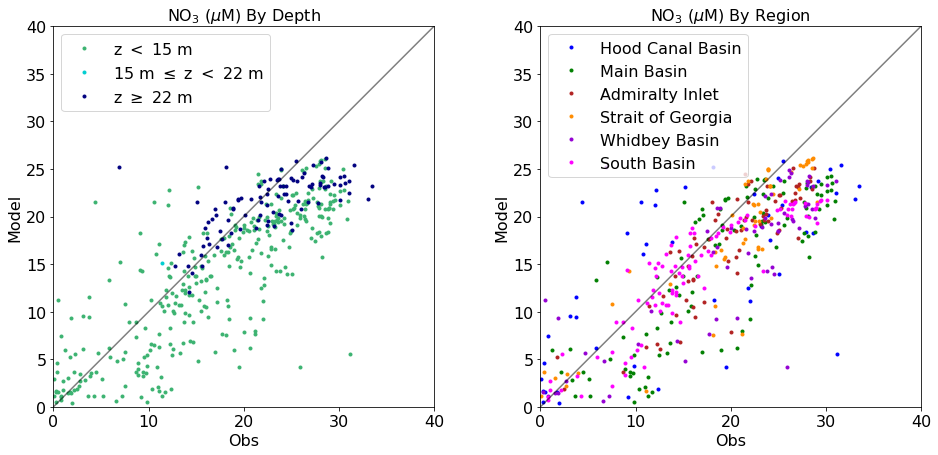

In [40]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data,ax[0],obsvar,modvar,(0,40))
ax[0].set_title('NO$_3$ ($\mu$M) By Depth')

ps,l=byRegion(data,datreg,ax[1],obsvar,modvar,(0,40))
ax[1].set_title('NO$_3$ ($\mu$M) By Region');

### Model vs Observed comparisons for individual seasons

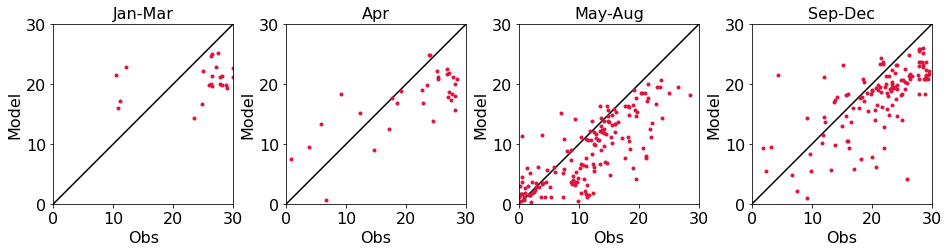

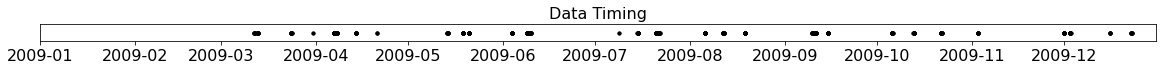

In [41]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(seasons,ax,obsvar,modvar,(0,30))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

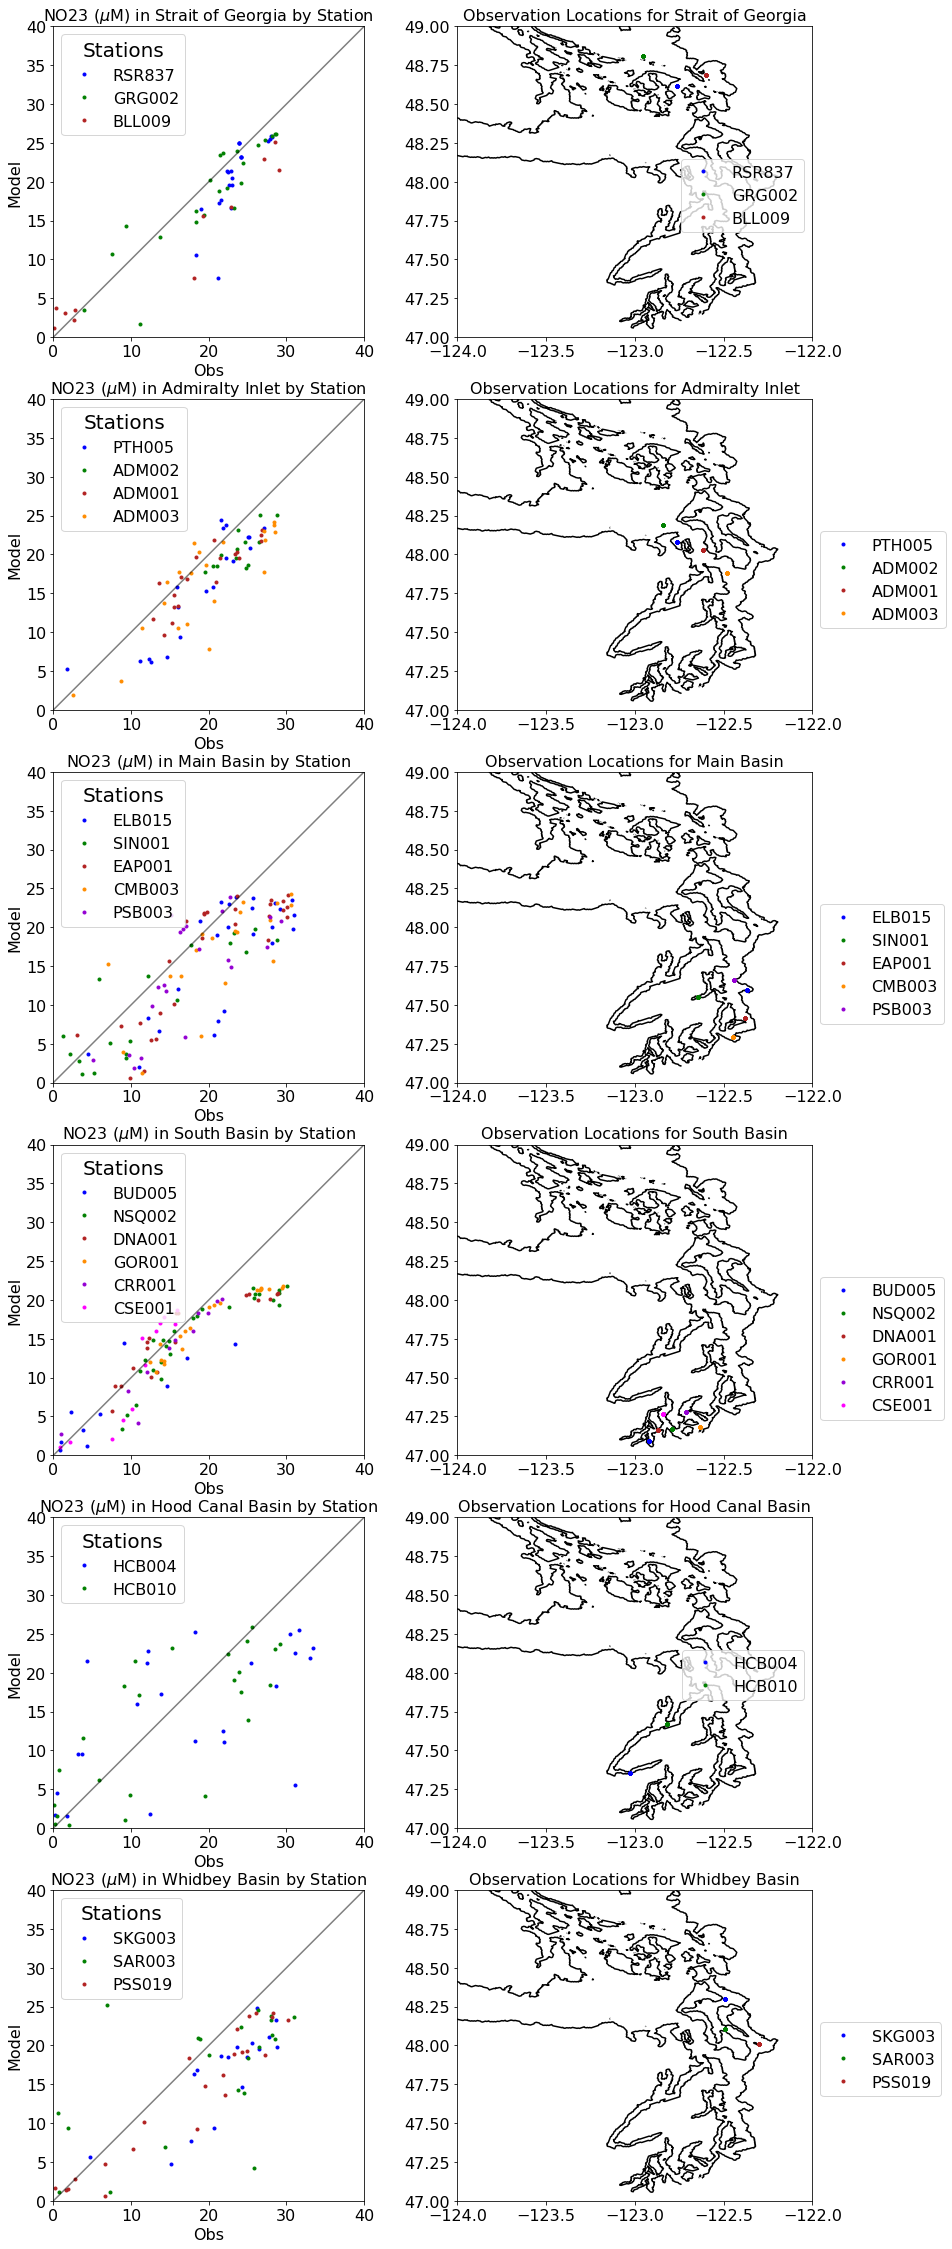

In [42]:
obsvar='NO23'
modvar='mod_nitrate'
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']
figrange=(0,40)

multi_station_graph(data,datstat,figrange,obsvar,modvar,regions)

# Dissolved Silica

### Table containing evaluation statistics for relevant subsets

In [43]:
# Defining Variables needed for silica determination 
obsvar='Si'
modvar='mod_silicon'
seasons=[JFM,Apr,MJJA,SOND]

In [44]:
statsDict[year]['dSi']=OrderedDict()
for isub in statsubs:
    statsDict[year]['dSi'][isub]=dict()
    var=statsDict[year]['dSi'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['dSi'],level='Subset',suborder=list(statsubs.keys()))
tbl

/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1136: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(np.sum((mod-obs)**2)/len(mod))
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1132: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-np.mean(obs))+np.abs(obs-np.mean(obs)))**2)


### Model vs Observed comparisons by depth and region

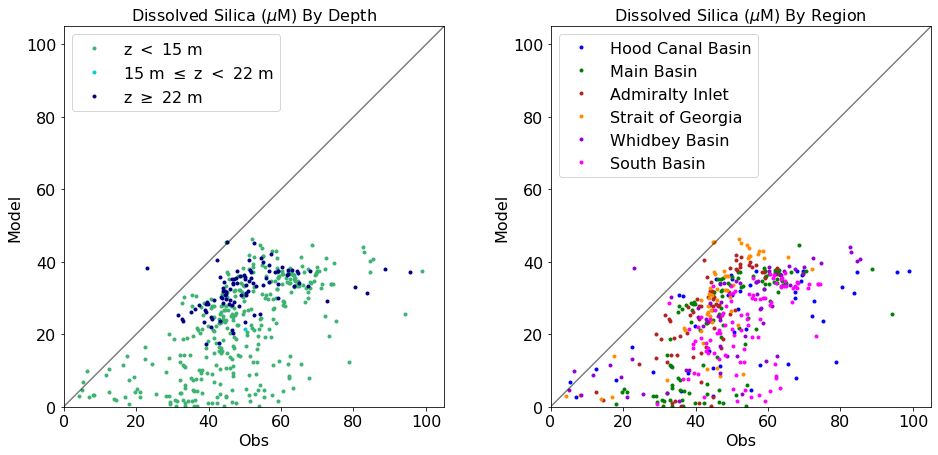

In [45]:
mv=(0,105)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data,ax[0],obsvar,modvar,mv)
ax[0].set_title('Dissolved Silica ($\mu$M) By Depth')

ps,l=byRegion(data,datreg,ax[1],obsvar,modvar,mv)
ax[1].set_title('Dissolved Silica ($\mu$M) By Region');

### Model vs Observed comparisons for individual seasons

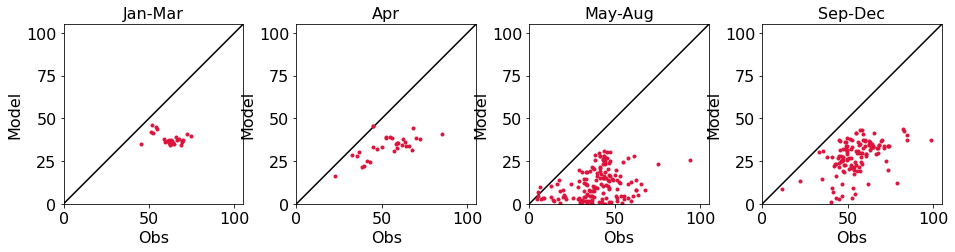

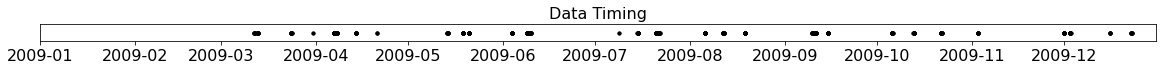

In [46]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(seasons,ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

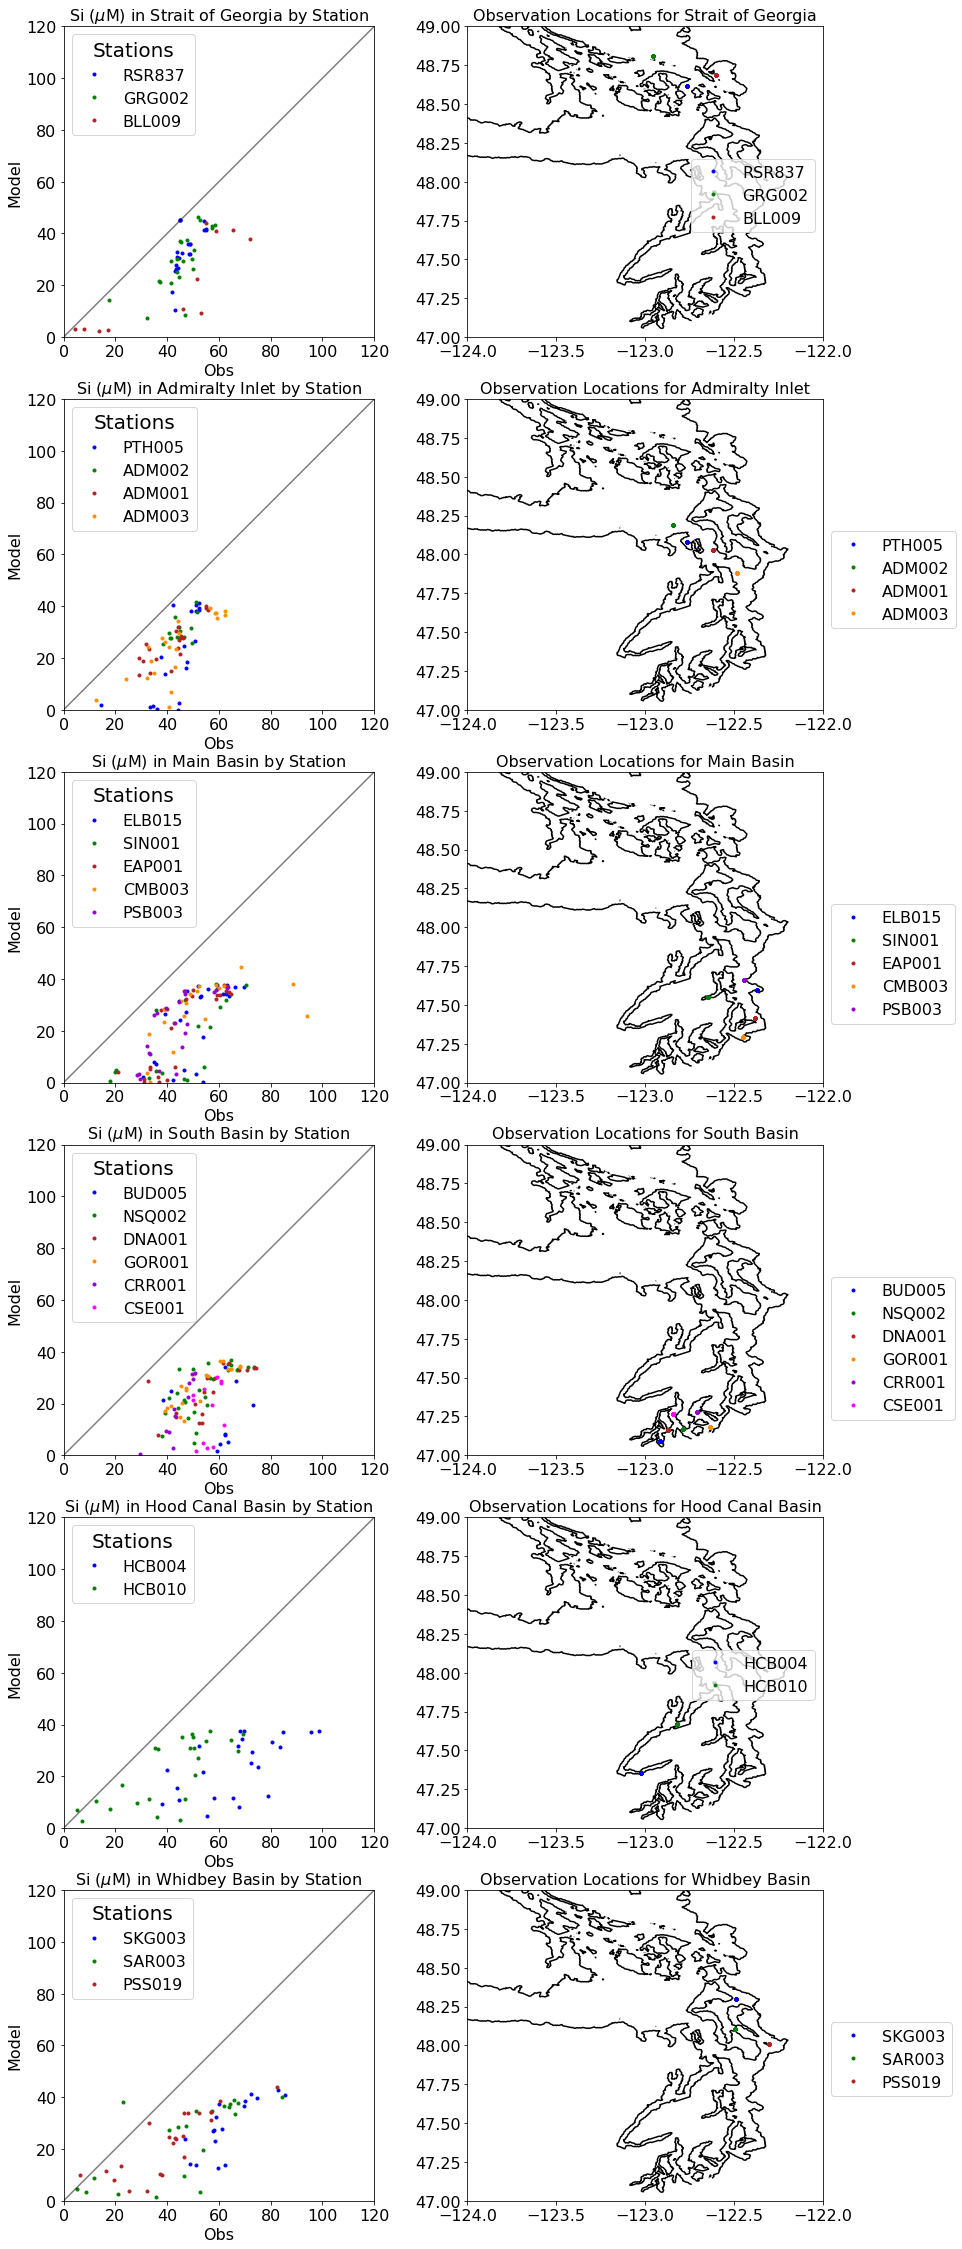

In [47]:
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']
figrange=(0,120)

multi_station_graph(data,datstat,figrange,obsvar,modvar,regions)

### Profiles of NO3 and Dissolved Silica

Text(0.5, 1.0, 'dSi')

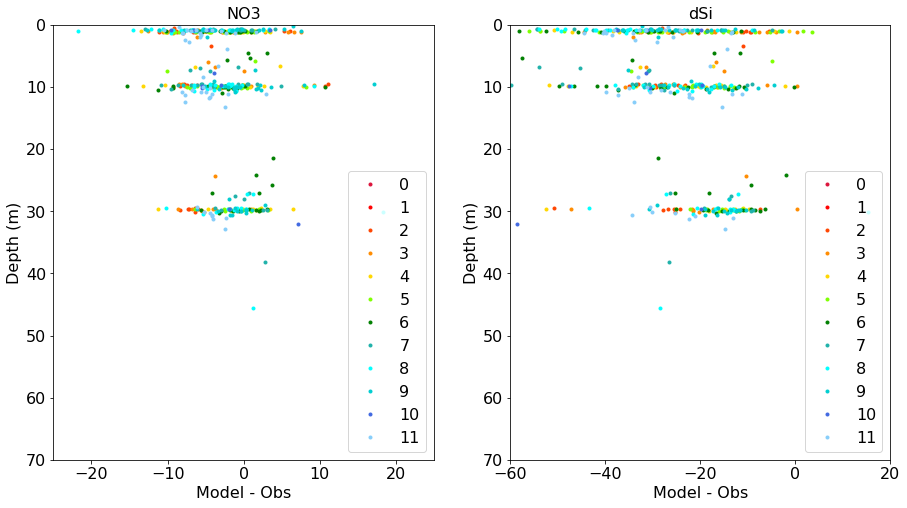

In [48]:
start_date = dt.datetime(year,1,1)
end_date = dt.datetime(year,12,31)

fig, ax = plt.subplots(1,2,figsize = (15,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'darkturquoise','royalblue','lightskyblue','blue','darkblue','mediumslateblue','blueviolet',
      'darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['NO23']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(70,0)
    axi.set_ylabel('Depth (m)')
ax[0].set_xlabel('Model - Obs')
ax[1].set_xlabel('Model - Obs')
ax[0].set_xlim(-25,25)
ax[1].set_xlim(-60,20)
ax[0].set_title('NO3')
ax[1].set_title('dSi')

# dSi:NO3 Ratios

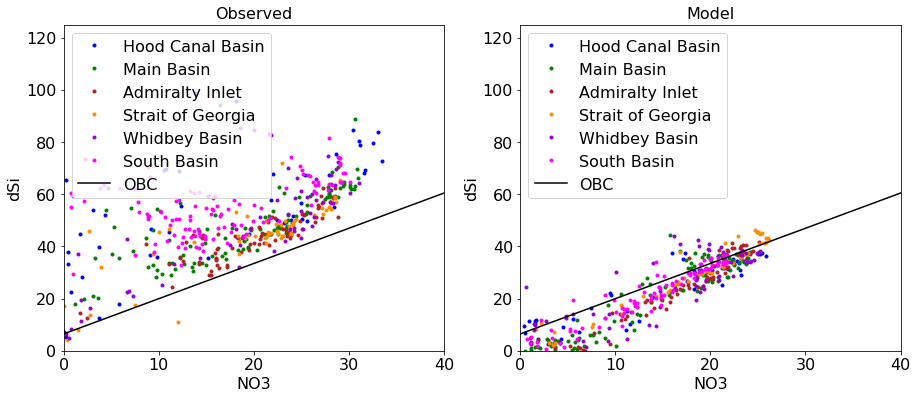

In [49]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
for ind,iregion in enumerate(data.Basin.unique()):
    p1=ax[0].plot(datreg[iregion]['NO23'],datreg[iregion]['Si'],'.',
                  color=colors[ind],label=iregion)
ax[0].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')  
ax[0].set_title('Observed')
ax[0].set_xlabel('NO3')
ax[0].set_ylabel('dSi')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,125)
ax[0].legend()

for ind,iregion in enumerate(data.Basin.unique()):
    p=ax[1].plot(datreg[iregion]['mod_nitrate'],datreg[iregion]['mod_silicon'],'.',  
                  color=colors[ind],label=iregion)
ax[1].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('NO3')
ax[1].set_ylabel('dSi')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,125)
ax[1].legend()
#ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
#ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

# NH4

### Table containing evaluation statistics for relevant subsets

In [50]:
# Defining Variables for determining Ammonium
obsvar='Amm'
modvar='mod_ammonium'
seasons=[JFM,Apr,MJJA,SOND]

In [51]:
statsDict[year]['NH4']=OrderedDict()
for isub in statsubs:
    statsDict[year]['NH4'][isub]=dict()
    var=statsDict[year]['NH4'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['NH4'],level='Subset',suborder=list(statsubs.keys()))
tbl

/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1136: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(np.sum((mod-obs)**2)/len(mod))
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1132: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-np.mean(obs))+np.abs(obs-np.mean(obs)))**2)


### Model vs Observed comparisons by depth and region

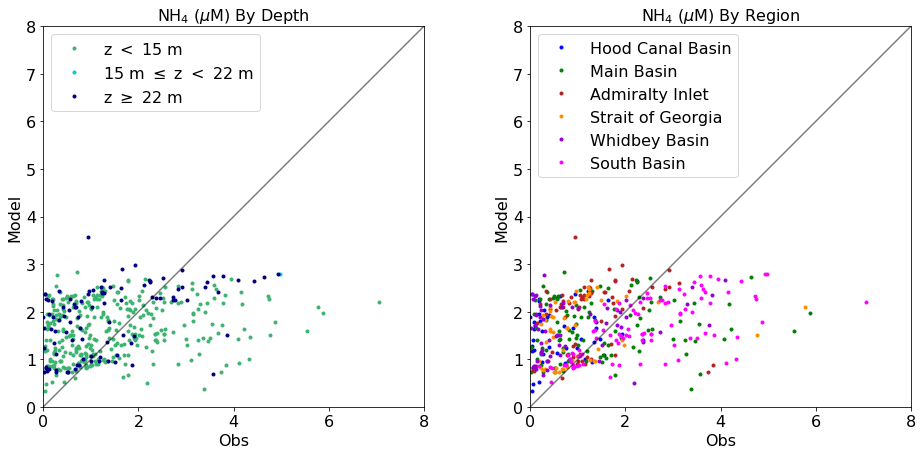

In [52]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data,ax[0],obsvar,modvar,(0,8))
ax[0].set_title('NH$_4$ ($\mu$M) By Depth')

ps,l=byRegion(data,datreg,ax[1],obsvar,modvar,(0,8))
ax[1].set_title('NH$_4$ ($\mu$M) By Region');

### Model vs Observed comparisons for individual seasons

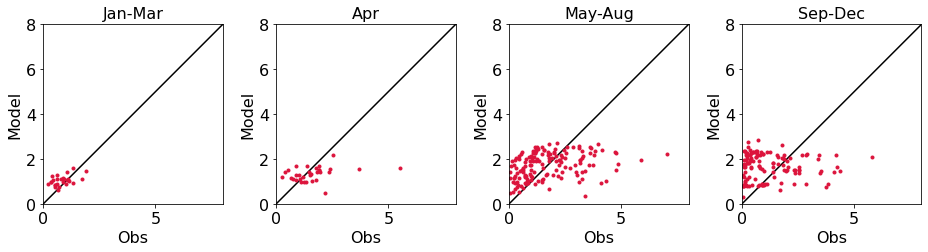

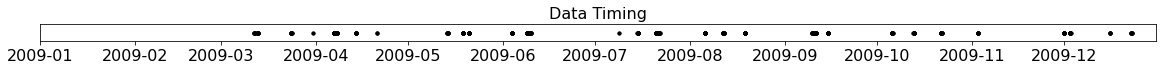

In [53]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(seasons,ax,obsvar,modvar,(0,8))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

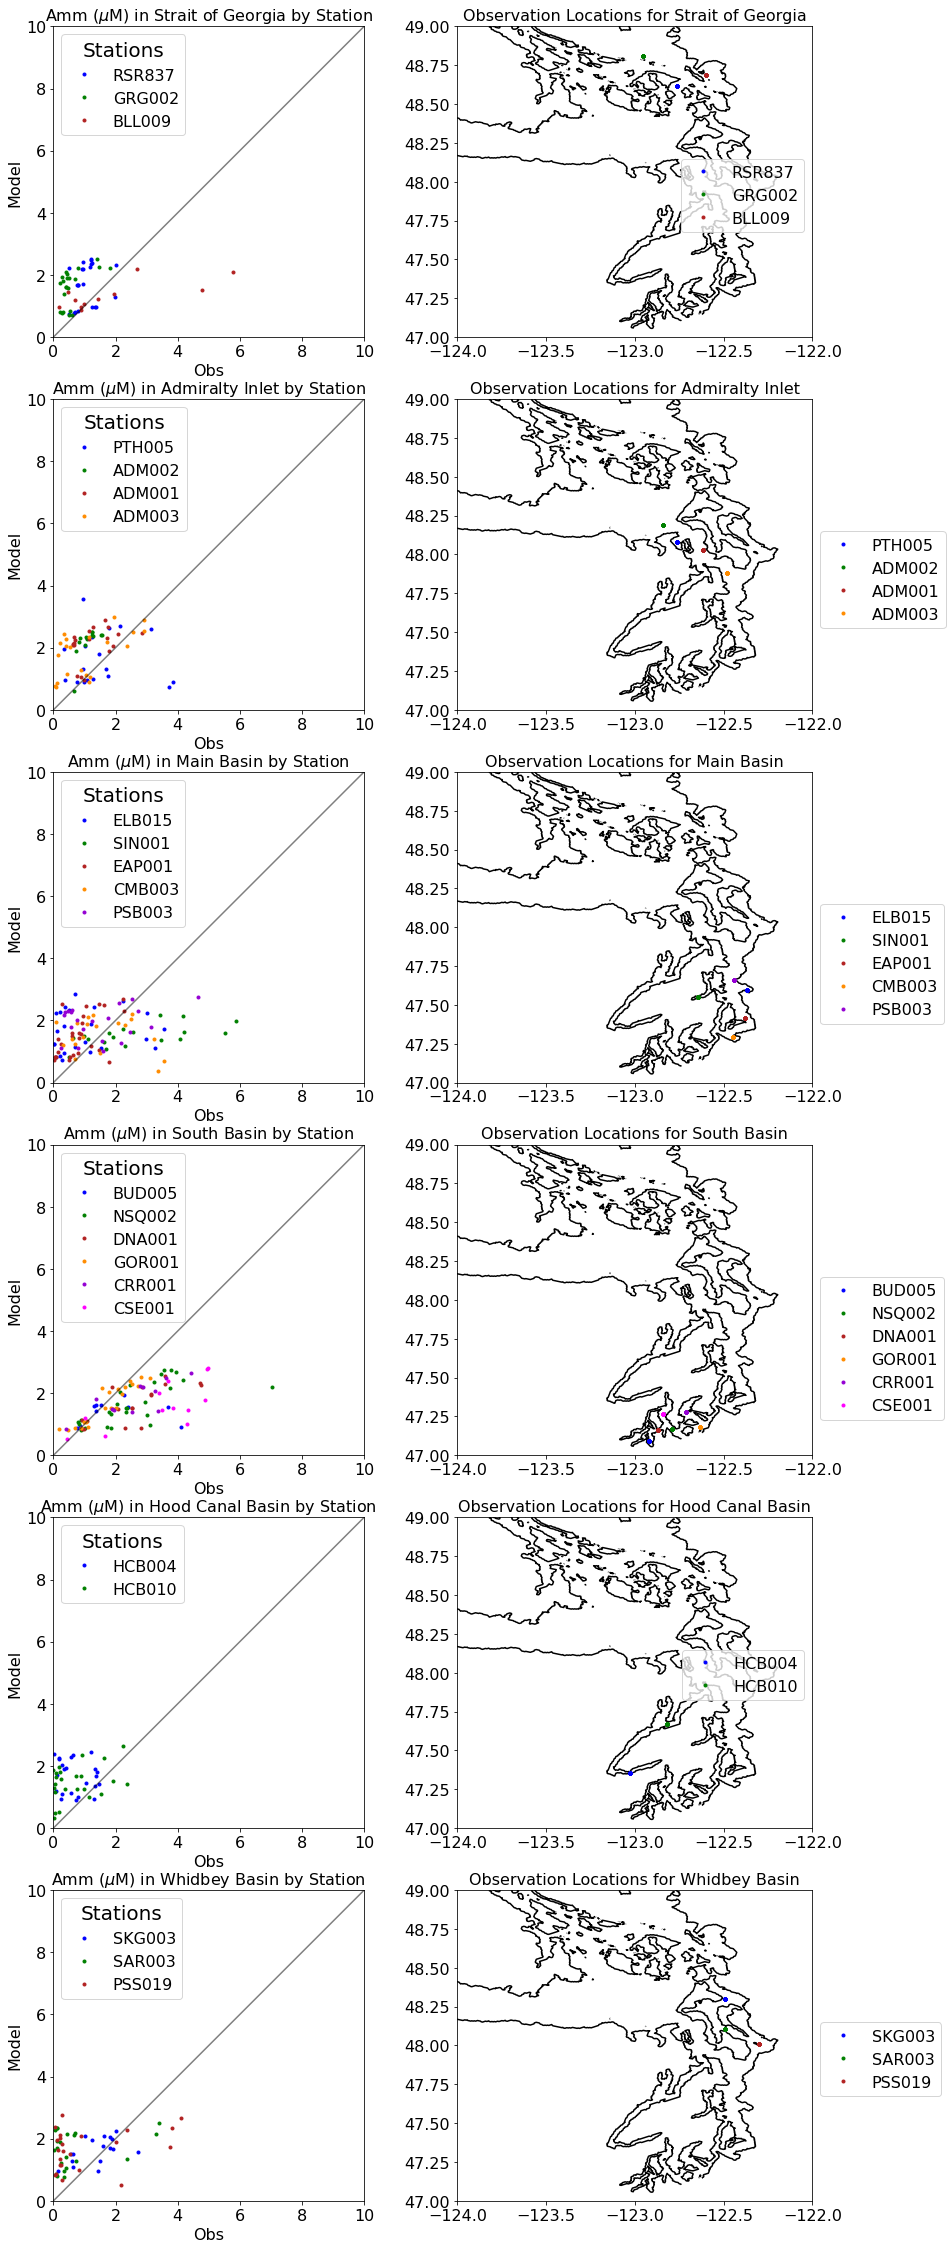

In [54]:
obsvar='Amm'
modvar='mod_ammonium'
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']
figrange=(0,10)

multi_station_graph(data,datstat,figrange,obsvar,modvar,regions)

## Error vs temperature

Text(0, 0.5, 'NH4 Error ($\\mu$M) Error')

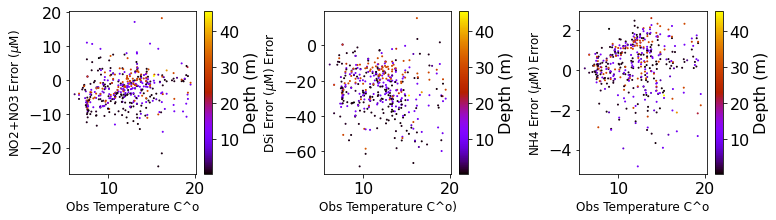

In [55]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.6)
m=ax[0].scatter(data['CT'],data['mod_nitrate']-data['NO23'],c=data['Z'],s=1,cmap='gnuplot') # what is a gnuplot and what are the other options for this?
cb=fig.colorbar(m,ax=ax[0],label='Depth (m)')
ax[0].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

m=ax[1].scatter(data['CT'],data['mod_silicon']-data['Si'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[1],label='Depth (m)')
ax[1].set_xlabel('Obs Temperature C^o)',fontsize=12)
ax[1].set_ylabel('DSi Error ($\mu$M) Error',fontsize=12)

m=ax[2].scatter(data['CT'],data['mod_ammonium']-data['Amm'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[2],label='Depth (m)')
ax[2].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[2].set_ylabel('NH4 Error ($\mu$M) Error',fontsize=12)

## Error vs salinity

Text(0, 0.5, 'NH4 Error ($\\mu$M) Error')

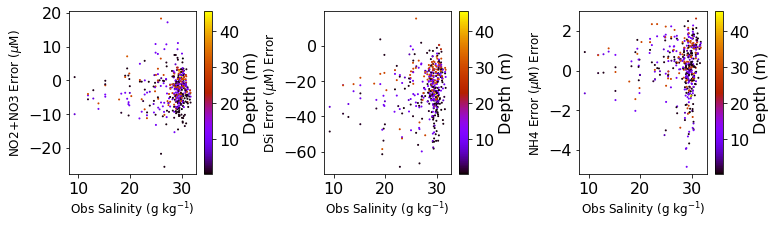

In [56]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.6)
m=ax[0].scatter(data['SA'],data['mod_nitrate']-data['NO23'],c=data['Z'],s=1,cmap='gnuplot') # what is a gnuplot and what are the other options for this?
cb=fig.colorbar(m,ax=ax[0],label='Depth (m)')
ax[0].set_xlabel('Obs Salinity (g kg$^{-1}$)',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

m=ax[1].scatter(data['SA'],data['mod_silicon']-data['Si'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[1],label='Depth (m)')
ax[1].set_xlabel('Obs Salinity (g kg$^{-1}$)',fontsize=12)
ax[1].set_ylabel('DSi Error ($\mu$M) Error',fontsize=12)

m=ax[2].scatter(data['SA'],data['mod_ammonium']-data['Amm'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[2],label='Depth (m)')
ax[2].set_xlabel('Obs Salinity (g kg$^{-1}$)',fontsize=12)
ax[2].set_ylabel('NH4 Error ($\mu$M) Error',fontsize=12)

## Error vs salinity error

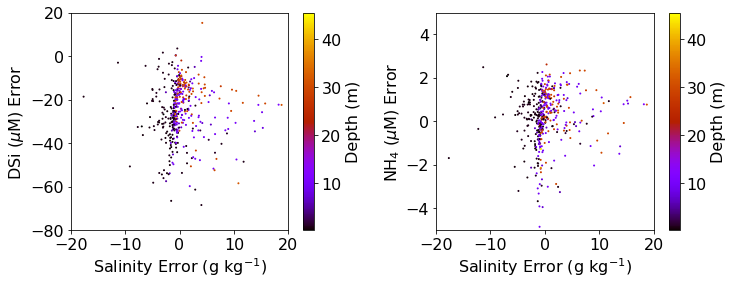

In [57]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[0].set_ylabel('DSi ($\mu$M) Error')
m,cb=ErrErr(fig,ax[0],'SA','mod_vosaline','Si','mod_silicon',(-20,20),(-80,20))
ax[1].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[1].set_ylabel('NH$_4$ ($\mu$M) Error')
m,cb=ErrErr(fig,ax[1],'SA','mod_vosaline','Amm','mod_ammonium',(-20,20),(-5,5))

## Error vs lat

Text(0, 0.5, 'NH4 Error ($\\mu$M) Error')

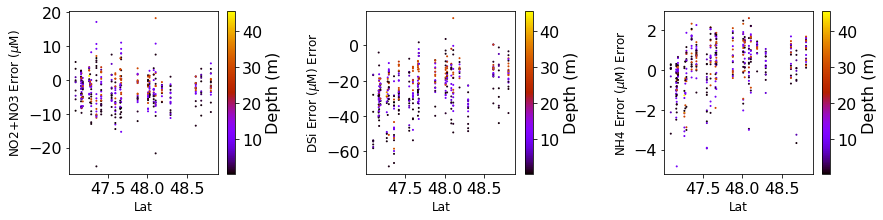

In [58]:
fig,ax=plt.subplots(1,3,figsize=(14,3))
fig.subplots_adjust(wspace=.6)
m=ax[0].scatter(data['Lat'],data['mod_nitrate']-data['NO23'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[0],label='Depth (m)')
ax[0].set_xlabel('Lat',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

m=ax[1].scatter(data['Lat'],data['mod_silicon']-data['Si'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[1],label='Depth (m)')
ax[1].set_xlabel('Lat',fontsize=12)
ax[1].set_ylabel('DSi Error ($\mu$M) Error',fontsize=12)

m=ax[2].scatter(data['Lat'],data['mod_ammonium']-data['Amm'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[2],label='Depth (m)')
ax[2].set_xlabel('Lat',fontsize=12)
ax[2].set_ylabel('NH4 Error ($\mu$M) Error',fontsize=12)

In [59]:
tbl,tdf=et.displayStats(statsDict[year],level='Variable',suborder=list(statsubs.keys()))
tbl